# Example application KKR Jij extraction and spirit LLG for estimation of Curie temperature in Fe and FeCo alloys

Motivated by [M. Ležaić, Ph. Mavropoulos and, S. Blügel, Appl. Phys. Lett. **90**, 082504 (2007)](https://pubs.aip.org/aip/apl/article/90/8/082504/128465)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from aiida import load_profile, orm, engine
from aiida_kkr.tools import plot_kkr, kkrparams
from aiida_kkr.workflows import kkr_scf_wc, kkr_dos_wc, kkr_jij_wc

_ = load_profile()

Version of workflow: 0.7.2


In [2]:
def load_or_submit(builder, uuid=None):
    if uuid is not None:
        return orm.load_node(uuid)
    calc = engine.submit(builder)
    print('submitted', calc)
    return calc

def load_or_create_group(label):
    try:
        group = orm.load_group(label)
    except:
        print('new group created with label', label)
        group = orm.Group(label=label)
        group.store()
    return group

def get_calc_from_group(calclabel, grouplabel):
    group = load_or_create_group(grouplabel)
    nodes = [i for i in group.nodes if i.label==calclabel]
    if len(nodes)==1:
        return nodes[0]
    else:
        print('calc not found', calclabel, grouplabel)
        return None
    
def submit_to_group(calclabel, grouplabel, builder, dry_run=False):
    group = load_or_create_group(grouplabel)
    if calclabel not in [i.label for i in group.nodes]:
        builder.metadata.label = calclabel
        print('submit', calclabel)
        if not dry_run:
            calc = load_or_submit(builder)
            group.add_nodes(calc)
        
    return group

In [3]:
!ssh iffslurm "sinfo -s"

PARTITION    AVAIL  TIMELIMIT   NODES(A/I/O/T) NODELIST
oscar           up   infinite         6/7/0/13 iffcluster[0102-0114]
th1             up   infinite        6/13/7/26 iffcluster[0701-0709,0711-0722,0724-0728]
th1-2020-32     up   infinite        16/0/2/18 iffcluster[1901-1905,1907-1909,1911-1920]
th1-2020-64     up   infinite        15/1/0/16 iffcluster[1801-1816]
th1-2020-gpu    up   infinite          1/2/0/3 iffcluster[2001-2003]
viti            up   infinite          3/2/1/6 iffcluster[0801-0804,0806-0807]


## DFT calculations for different lattice constants

### KKR self-consistency

In [4]:
# prepare kkr_scf builder
builder = kkr_scf_wc.get_builder()

# scf settings
scf_settings = kkr_scf_wc.get_wf_defaults(silent=True)[0]
scf_settings['mag_init'] = True
scf_settings['check_dos'] = False
scf_settings['nsteps'] = 200

# code that uses intel nodes
kkr_code = orm.load_code('kkrhost_3.5_intel@iffslurm')
voronoi_code = orm.load_code('voronoi@localhost')
builder.kkr = kkr_code
builder.voronoi = voronoi_code

options = orm.Dict({
    'withmpi': True,
    'resources': {'num_machines': 1,
                  'tot_num_mpiprocs': 12, 
                  'num_cores_per_mpiproc': 1},
    'queue_name': 'oscar', # select intel nodes
    'custom_scheduler_commands': 'export OMP_NUM_THREADS=1\n',
    'max_wallclock_seconds': 3600 # 1 hour max runtime
})
builder.options = options

# calculation parameters: KEXCOR=4 means GGA (PBE)
builder.calc_parameters = orm.Dict(kkrparams(NSPIN=2, LMAX=3, RMAX=10, GMAX=100, KEXCOR=4))

# get original lattice constant for Fe from ase structure builder
alat0 = bulk('Fe').cell[0][1]*2

#submit calculation for scaled lattice constants to group
grouplabel_scf = 'Fe_bcc:scf'
for scale_fac in [0.98, 1.0]:
    # create bcc Fe structure with scaled lattice constant
    struc = orm.StructureData(ase=bulk('Fe', 'bcc', a = alat0*scale_fac))
    builder.structure = struc
    # submit calculation to group (calclabel determines if a calculation exists in group or not yet)
    calclabel = f'alat_scale={scale_fac:.3f}'
    group_scf = submit_to_group(calclabel, grouplabel_scf, builder, dry_run=True)

    # CPA structures for 50/50 Fe Co
    struc = orm.StructureData(cell=struc.cell)
    struc.append_atom(position=[0,0,0], symbols=('Fe', 'Co'), weights=(0.5, 0.5))
    builder.structure = struc
    # submit calculation to group (calclabel determines if a calculation exists in group or not yet)
    calclabel = f'Fe_Co:alat_scale={scale_fac:.3f}'
    group_scf = submit_to_group(calclabel, grouplabel_scf, builder, dry_run=False)
    
# [(i.label, i.pk, i.process_state, i.exit_status) for i in group_scf.nodes]

In [5]:
%%capture --no-display

# plot_kkr(get_calc_from_group('Fe_Co:alat_scale=1.000', grouplabel_scf), silent=True) #, strucplot=True)

In [6]:
print('GGA spin moments for different lattice constants (in mu_B):')
e0 = -34632.277440021-0.0010653260032995604
for i in group_scf.nodes:
    if i.is_finished_ok:
        print(i.label, i.outputs.last_calc_out['magnetism_group']['total_spin_moment'], i.outputs.last_calc_out['energy']-e0, i.outputs.last_calc_out['energy_unit'])

GGA spin moments for different lattice constants (in mu_B):
alat_scale=0.980 2.130245 0.012102808002964593 eV
alat_scale=1.000 2.224858 0.0010653260032995604 eV
Fe_Co:alat_scale=0.980 2.157168 -1641.7220123579973 eV
Fe_Co:alat_scale=1.000 2.210244 -1641.7400778610026 eV


### DOS calculations

In [7]:
# set up dos builder
builder = kkr_dos_wc.get_builder()
# overview DOS in -10..5 eV range around EF
builder.wf_parameters = orm.Dict(dict={'nepts': 96, 'tempr': 200.0, 'emin': -10.0, 'emax': 5.0, 'kmesh': [50, 50, 50]})
builder.kkr = kkr_code
builder.options = options

grouplabel_dos = 'Fe_bcc:dos'

# prepare process builders for missing jobs
for scf in group_scf.nodes:
    if scf.is_finished_ok:
        builder.remote_data = scf.outputs.last_RemoteData
        group_dos = submit_to_group(scf.label, grouplabel_dos, builder, dry_run=False)

# [(i.label, i.pk, i.process_state, i.exit_status) for i in group_dos.nodes]

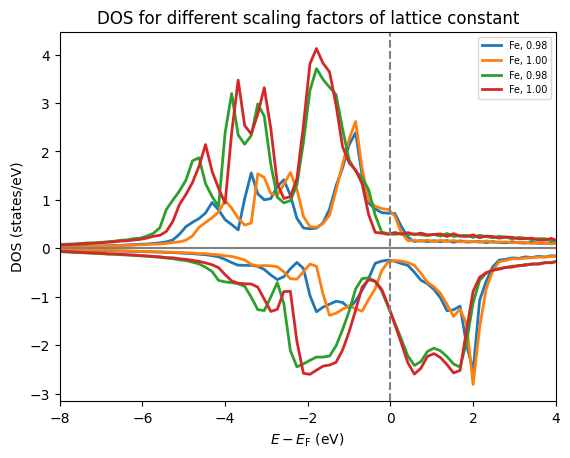

In [8]:
%%capture --no-display

plt.figure()
i = 0
for dos in group_dos.nodes:
    if dos.is_finished_ok:
        lw = 2
        alpha = 1.
        color=f'C{i}'
        label=dos.label.split('=')[1][:-1]
        if 'Co' in label:
            label  = 'Fe$_{0.5}$Co$_{0.5}$, '+label
        else:
            label  = 'Fe, '+label
        plot_kkr(dos, silent=True, noshow=True, nofig=True, l_channels=False, color=color, label=label, lw=lw, alpha=alpha)
        i += 1
plt.title('DOS for different scaling factors of lattice constant')
plt.xlabel(r'$E-E_\mathrm{F}$ (eV)')
plt.axhline(0, color='grey', ls='-')
plt.axvline(0, color='grey', ls='--')
plt.xlim(-8,4)
plt.show()

### Calculate Jijs

In [9]:
# set up Jij calculation builder
builder = kkr_jij_wc.get_builder()
# calculate Jij's up to a distance of 10 Ang., this requires increasing max array sizes
builder.wf_parameters = orm.Dict({
    'jijrad_ang': 10.0,
    'accuracy': {'NATOMIMPD': 5000, 'NSHELD': 5000}
    })
builder.kkr = kkr_code
builder.options = options
grouplabel_Jij = 'Fe_bcc:Jij'

# prepare process builders for missing jobs
for scf in group_scf.nodes:
    if scf.is_finished_ok:
        builder.remote_data = scf.outputs.last_RemoteData
        if 'Fe_Co' in scf.label:
            # activate SOC solver for CPA calculations for proper parsing of results
            builder.params_kkr_overwrite = orm.Dict(dict(kkrparams(USE_CHEBYCHEV_SOLVER=True, NCHEB=12, NPAN_EQ=8, NPAN_LOG=17, R_LOG=0.6, SET_CHEBY_NOSOC=True).get_set_values()))

        group_Jij = submit_to_group(scf.label, grouplabel_Jij, builder, dry_run=False)

# [(i.label, i.pk, i.process_state, i.exit_status) for i in group_Jij.nodes]

In [10]:
def average_jij(jij_data):
    """Average the Jij data for CPA calculations among differtnet species, assumes equal concentration"""
    jij = jij_data.get_array('Jij_expanded')
    pos = jij_data.get_array('positions_expanded')

    r = pos[jij[:,0]==0]
    j = jij[jij[:,0]==0]
    r00 = r[j[:,1]==0]
    j00 = j[j[:,1]==0]
    r01 = r[j[:,1]==1]
    j01 = j[j[:,1]==1]
    
    
    r = pos[jij[:,0]==1]
    j = jij[jij[:,0]==1]
    r10 = r[j[:,1]==0]
    j10 = j[j[:,1]==0]
    r11 = r[j[:,1]==1]
    j11 = j[j[:,1]==1]
    
    r = r00
    j = j00[:,:6]
    if len(j01)>0:
        j[:,5] = (j00[:,5] + j01[:,5] + j10[:,5] + j11[:,5]) / 4
            
    
    jij_data_averaged = orm.ArrayData()
    jij_data_averaged.set_array('Jij_expanded', j)
    jij_data_averaged.set_array('positions_expanded', r)

    return jij_data_averaged

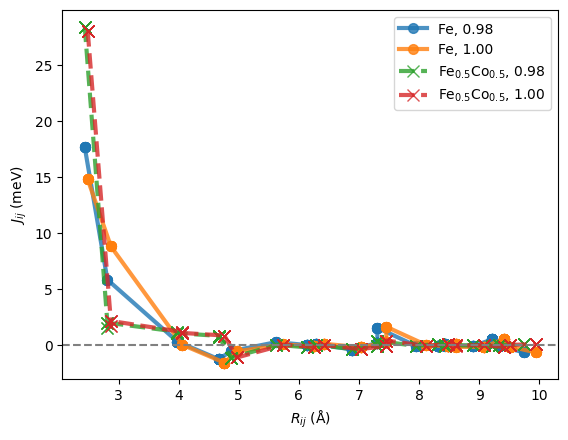

number of shells up to cutoff radius: 17


In [11]:
%%capture --no-display --no-stdout

plt.figure()
i = 0
for jij_calc in group_Jij.nodes:
    if jij_calc.is_finished_ok:
        jij_data = jij_calc.outputs.jij_data
        if 'Co' in jij_calc.label:
            jij_data = average_jij(jij_data)
        R_ij = np.linalg.norm(jij_data.get_array('positions_expanded'), axis=1)
        J_ij = jij_data.get_array('Jij_expanded')[:,5]
        # sort by distance
        isort = R_ij.argsort()
        R_ij, J_ij = R_ij[isort], J_ij[isort]
        
        # plot
        lw = 3
        alpha = 0.8
        color=f'C{i}'
        ms = 7
        ls = '-'
        marker='o'
        label = jij_calc.label.split('=')[1][:-1]
        if 'Co' in jij_calc.label:
            add = r'Fe$_\mathrm{Co}$, '
            ls = '--'
            marker='x'
            ms = 8
            label  = 'Fe$_{0.5}$Co$_{0.5}$, '+label
        else:
            label  = 'Fe, '+label
        plt.plot(R_ij, J_ij, 'o-', color=color, ms=ms, marker=marker, label=label, lw=lw, alpha=alpha, ls=ls)
        # plt.bar(x=R_ij, height=J_ij, width=0.01, color=color, label=jij_calc.label.split('=')[1][:-1], lw=lw, alpha=alpha)  
        i += 1
        
plt.legend()
plt.axhline(0, color='grey', ls='--')
plt.ylabel(r'$J_{ij}$ (meV)')
plt.xlabel(r'$R_{ij}$ ($\mathrm{\AA}$)')
plt.show()

print('number of shells up to cutoff radius:', len(np.unique(np.round(R_ij,5))))

In [12]:
%%capture --no-stdout
print('arrays in output data:', jij_calc.outputs.jij_data.get_arraynames())
print('description of output arrays:')
print('columns in "Jij_expanded":', jij_calc.outputs.jij_data.extras['array_descriptions']['Jij_expanded'])
print('columns in "positions_expanded":', jij_calc.outputs.jij_data.extras['array_descriptions']['positions_expanded'])

arrays in output data: ['Jij_expanded', 'positions_expanded']
description of output arrays:
columns in "Jij_expanded": i, j, da, db, dc, Jij (meV) [, Dij vector (x, y, z in meV), full Jij tensor (xx, xy, xz, yx, yy, yz, zx, zy, zz in meV)]
columns in "positions_expanded": x, y, z (Ang.) positions of all pairs in Jij_expanded


---

## 2. Spirit calculations

In [13]:
from aiida_spirit.calculations import SpiritCalculation

In [14]:
!verdi code list | grep -i spirit

spirit@iffslurm                                              13  core.code
spirit_pypi@localhost (Imported #1)                       27646  core.code


In [15]:
builder = SpiritCalculation.get_builder()

builder.code = orm.load_code('spirit@iffslurm')
builder.metadata.options = {
    'withmpi': True,
    'resources': {'num_machines': 1,
        'tot_num_mpiprocs': 1,
        'num_cores_per_mpiproc': 1},
    'queue_name': 'oscar',
    'max_wallclock_seconds': 3600,
    'custom_scheduler_commands': '#SBATCH --exclusive\n\nexport OMP_NUM_THREADS=12'
}

builder.run_options = orm.Dict({
    'simulation_method': 'llg',
    'solver': 'depondt', # Depondt solver to take temperature into account
    })

parameters_llg = {
        # temperature noise (in K)
        'llg_temperature': 100.,
        # small external field of 5 mT
        'external_field_magnitude': 0.005,
        # external field points in z direction
        'external_field_normal': [0.0, 0.0, 1.0],
        # change spin moment to have the right size for Fe, not used though
        'mu_s': [2.2],
        # limit the number of LLG iterations
        'llg_n_iterations': 10000,
        'llg_n_iterations_log': 500,
        # periodic boundary conditions
        'boundary_conditions': [True, True, True],
        # size of spirit supercell
        'n_basis_cells': [20, 20, 20],
    }

for jij_calc in list(group_Jij.nodes):
    if jij_calc.is_finished_ok:
        # individual groups for each lattice constant
        grouplabel_spirit = 'Fe_bcc:spirit:'+jij_calc.label
        print(grouplabel_spirit)

        # set builder and submit to group
        builder.structure = jij_calc.outputs.structure_jij_sites
        jij_data = jij_calc.outputs.jij_data
        if 'Co' in jij_calc.label:
            jij_data = average_jij(jij_data)
        builder.jij_data = jij_data
        for T in np.linspace(0., 2000., 21):
            ms = get_calc_from_group(jij_calc.label, grouplabel_scf).outputs.last_calc_out['magnetism_group']['spin_moment_per_atom']
            if 'Co' in jij_calc.label:
                ms = [np.mean(ms)]
            parameters_llg['mu_s'] = ms # set list of spin moments
            parameters_llg['llg_temperature'] = T
            builder.parameters = orm.Dict(parameters_llg)
            calclabel = f'T={T:.1f}'
            # submit to group
            group_spirit = submit_to_group(calclabel, grouplabel_spirit, builder, dry_run=False)

# [(i.label, i.pk, i.process_state, i.exit_status) for i in group_spirit.nodes]

Fe_bcc:spirit:alat_scale=0.980
Fe_bcc:spirit:alat_scale=1.000
Fe_bcc:spirit:Fe_Co:alat_scale=0.980
Fe_bcc:spirit:Fe_Co:alat_scale=1.000


In [16]:
def get_spirit_calc(alat_scale=1.0, T=100., Fe_Co=False):
    grouplabel_spirit = f'Fe_bcc:spirit:alat_scale={alat_scale:.3f}'
    if Fe_Co:
        grouplabel_spirit = grouplabel_spirit.replace('spirit:', 'spirit:Fe_Co:')
    calclabel = f'T={T:.1f}'
    return get_calc_from_group(calclabel, grouplabel_spirit)

In [17]:
def plot_e_convergence(spirit_calc):
    e = spirit_calc.outputs.energies.get_array('energies')
    plt.plot(e[:,0], e[:,1], 'o-')
    plt.ylabel('E_tot')
    plt.twinx()
    plt.plot(e[:,0], abs(e[:,1]-e[-1,1]), 'o-', color='C1')
    plt.yscale('log')
    plt.ylabel('diff to last value')
    plt.xlabel('LLG iteration')
    plt.show()

In [18]:
from aiida_spirit.tools.plotting import init_spinview, show_spins

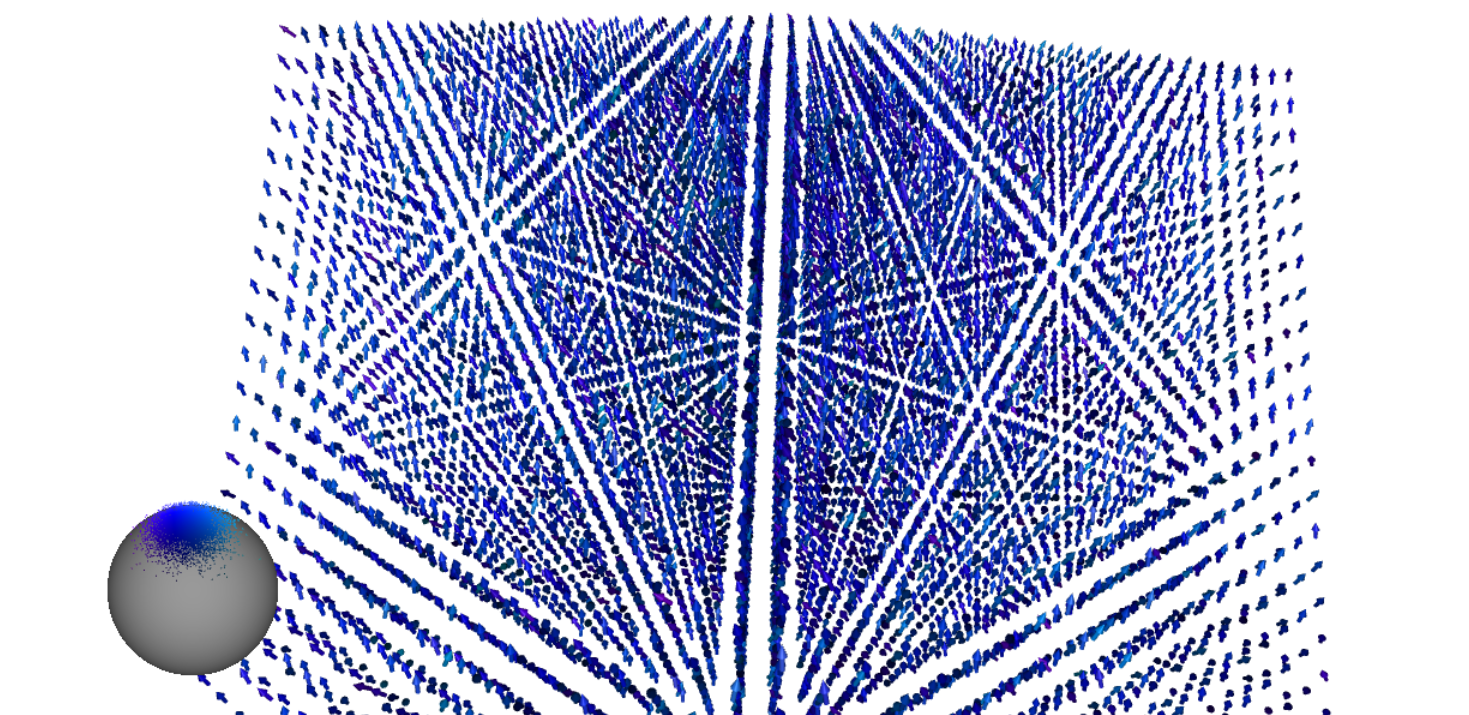

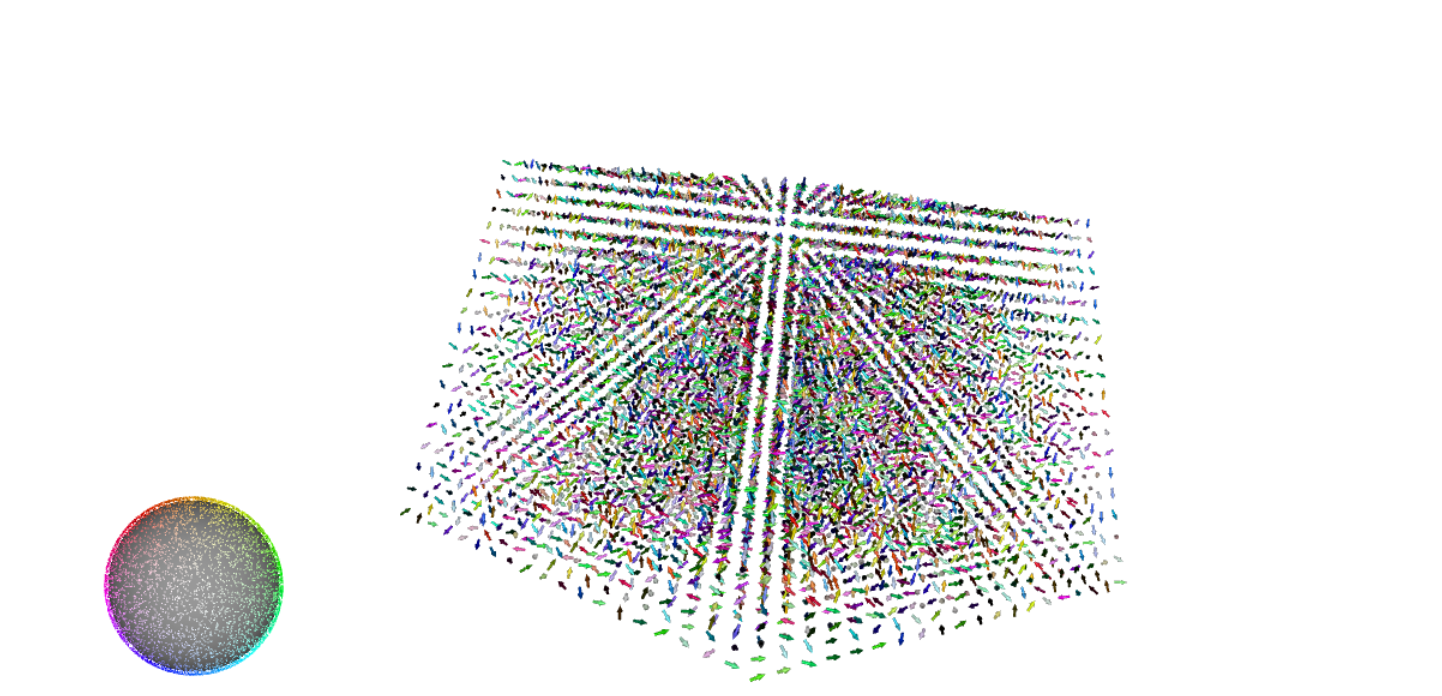

### analyze $T_C$

In [19]:
def plot_m_vs_T(alat_scale=1.0, Fe_Co=False, show=True, figure=True, title=True, marker='o', ls='-'):
    data_all = []
    for T in np.linspace(0,2000,21):
        spirit_calc = get_spirit_calc(alat_scale, T, Fe_Co)
        if spirit_calc.is_finished_ok:
            m_final = spirit_calc.outputs.magnetization.get_array('final')
            # print(spirit_calc.label, np.mean(m_final, axis=0), np.linalg.norm(np.mean(m_final, axis=0)), np.std(m_final, axis=0), np.linalg.norm(np.std(m_final, axis=0)))
            m_aver =  np.linalg.norm(np.mean(m_final, axis=0))
            m_std =  np.linalg.norm(np.std(m_final, axis=0))
            data_all.append([T, m_aver, m_std])
    data_all = np.array(data_all)

    if len(data_all)>0:
        if figure:
            plt.figure()
        if not title:
            plt.plot(data_all[:,0], data_all[:,1], ls=ls, marker=marker, label='|mean(m)|')
            plt.plot(data_all[:,0], data_all[:,2], ls=ls, marker=marker, label='|std(m)|')
        else:
            plt.plot(data_all[:,0], data_all[:,1], ls=ls, marker=marker, label='|mean(m)|'+f', {alat_scale:.2f}')
            plt.plot(data_all[:,0], data_all[:,2], ls=ls, marker=marker, label='|std(m)|'+f', {alat_scale:.2f}')
        plt.ylim(0, 1.05)
        plt.xlim(0,2000)
        plt.xlabel('T (K)')
        plt.ylabel('M')
        plt.legend()
        if title:
            plt.title(f'alat scale factor={alat_scale}')
        if show:
            plt.show()
    else:
        print(f'no data yet for alat scale factor={alat_scale}')

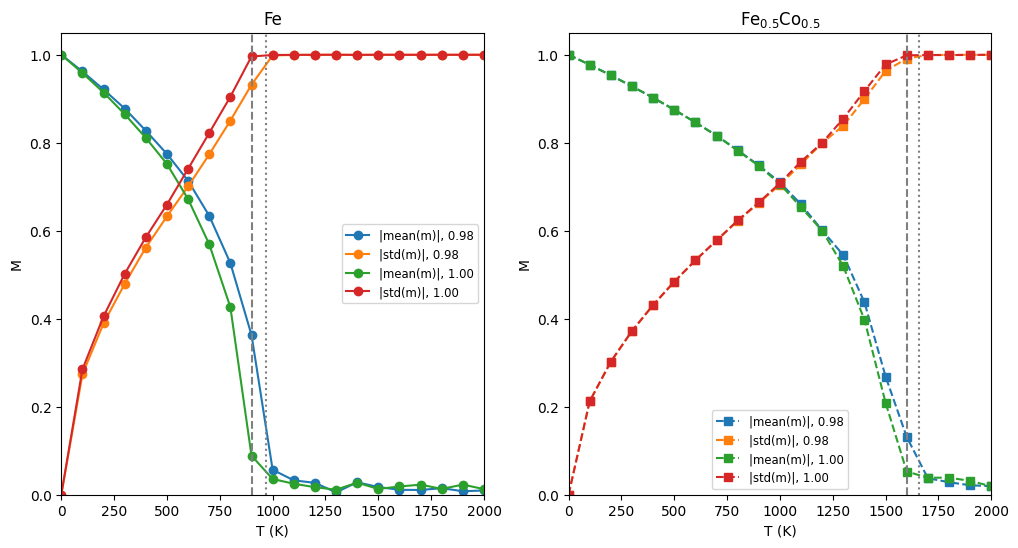

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for scale in [0.98, 1.0]:
    plot_m_vs_T(scale, figure=False, show=False)
plt.axvline(900, ls='--', color='grey')
plt.axvline(970, ls=':', color='grey')
plt.legend(fontsize='small')
plt.title('Fe')

plt.subplot(1,2,2)
for scale in [0.98, 1.0]:
    plot_m_vs_T(scale, figure=False, show=False, Fe_Co=True, ls='--', marker='s')
plt.axvline(1600, ls='--', color='grey')
plt.axvline(1660, ls=':', color='grey')
plt.legend(fontsize='small')
plt.title(r'Fe$_{0.5}$Co$_{0.5}$')
plt.show()

### compare to paper: [M. Ležaić, Ph. Mavropoulos and, S. Blügel, Appl. Phys. Lett. **90**, 082504 (2007)](https://pubs.aip.org/aip/apl/article/90/8/082504/128465):
	
|Alloy  |  a (Å)|   $M_\mathrm{Fe}$ ($\mu_B$)	| $M_\mathrm{Co}$ ($\mu_B$)   |  $T_C$ (K)|
|-------|-------|-----------|---------|-------|
|Fe bcc | 2.804 |	2.107 	| ⋯ 	  |  970  |
|       | 2.857 |	2.197 	| ⋯ 	  |  900  |
|Fe$_{0.5}$Co$_{0.5}$   | 2.857 |	2.588 	| 1 .801  |	1600  |
|Fe$_{0.5}$Co$_{0.5}$   | 2.804 |	2.729 	| 1.727   | 1660  |

## Visualize provenance graph from a starting structure